In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image

(309, 465, 3)


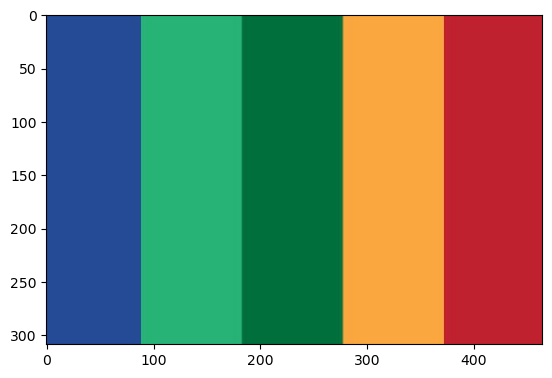

In [2]:
file = r"...\images for practice\blue to red flag.jpg"
imgog =  image.imread(file)
print(imgog.shape)
plt.imshow(imgog)

#### function to turn the image to grayscale, ie, 2D

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

imgray = rgb2gray(imgog)

#### here I scale between 0-1

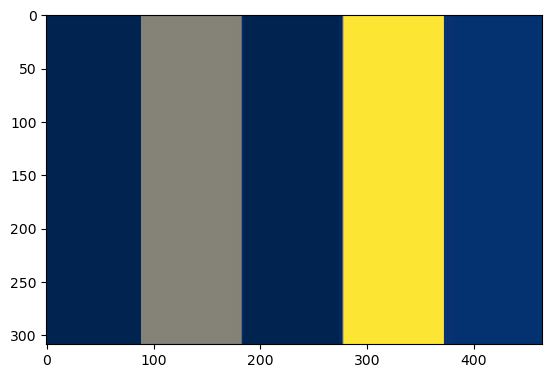

In [4]:
imgray = (imgray - np.min(imgray))/(np.max(imgray)-np.min(imgray))

plt.imshow(imgray,cmap='cividis')

#### now, I am going to remove 25% of the pixels 

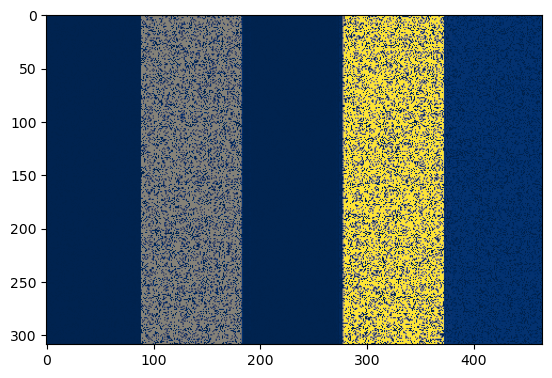

In [5]:
img = imgray.copy()
img0 = imgray.copy()
m,n = img.shape
zero_mask = np.random.rand(m, n) > 0.75
img[zero_mask] = 0
nonzeros = (~zero_mask).sum() 

plt.imshow(img,cmap='cividis')

#### 2: PFBS algorithm for matrix completion

note:\
the smaller lambda is: 
1. the more singular values are kept, 
2. the lower the error is, and 
3. the less smoothed the recovered image is

This lambda is very easy to optimize. It can before by simple trial and error, which is all I did here....

In [6]:
# initializing 
Y = np.zeros((m, n))
delta = m*n/nonzeros 

lam = 1 # lambda
tau = lam*delta

# algorithm
y_change, error, yerror = [], [], 10
for _ in range(25):
    
    u, s, vh = np.linalg.svd(Y,full_matrices=False)
    s_t = np.maximum(s-tau, 0)
    
    Z = (u[:, :n]*s_t)@vh # reconstruction of matrix
    
    P = img-Z
    P[zero_mask] = 0
    
    Y0 = Y.copy()
    Y = Z + delta*P
    
    # collections for plotting
    yerror = ((Y-Y0)**2).sum()
    y_change.append(yerror) 
    error.append(np.mean((img0-Z)**2)) 
    
no_singles = np.sum(s_t>0)
print(f'singulars > 0: {no_singles}',end='\r')

#### 2. visuals and results

very good recovery is acheived with less than half the singular values

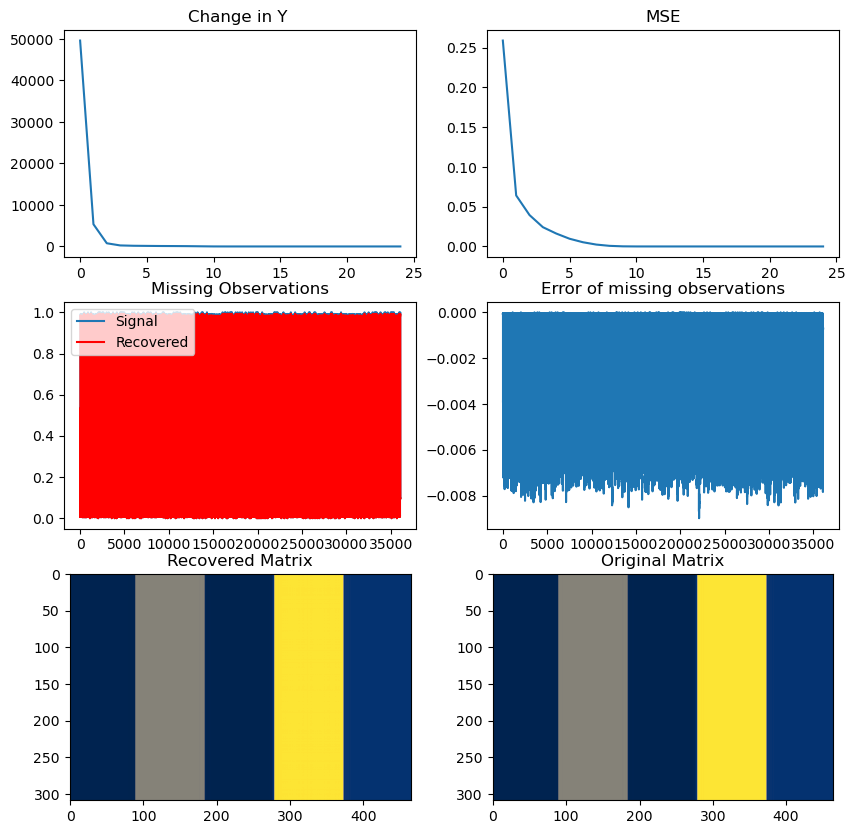

In [7]:
Xr = img0[zero_mask]
Zr = Z[zero_mask]

# plot the results
fig, ax = plt.subplots(3,2,figsize=(10,10))
ax[0,0].plot(y_change)
ax[0,0].set_title('Change in Y ')

ax[0,1].plot(error)
ax[0,1].set_title('MSE')

ax[1,0].plot(Xr, label='Signal')
ax[1,0].plot(Zr, 'r', label='Recovered')
ax[1,0].set_title('Missing Observations')
ax[1,0].legend()

ax[1,1].plot(Zr-Xr)
ax[1,1].set_title('Error of missing observations')

ax[2,0].imshow(Z,cmap='cividis')
ax[2,0].set_title('Recovered Matrix')

ax[2,1].imshow(img0,cmap='cividis')
ax[2,1].set_title('Original Matrix')
plt.show()

#### Same process different image

(542, 542, 3)


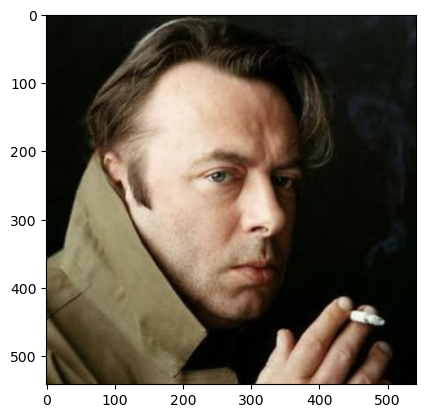

In [8]:
file = r"...\images for practice\hitchens _ coat cig.jpg"
imgog =  image.imread(file)
print(imgog.shape)
plt.imshow(imgog)

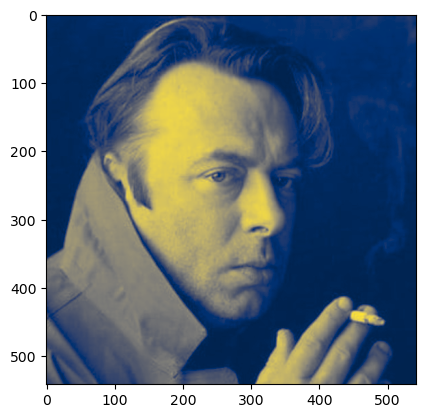

In [9]:
imgray = rgb2gray(imgog)
imgray = (imgray - np.min(imgray))/(np.max(imgray)-np.min(imgray))
plt.imshow(imgray,cmap='cividis')

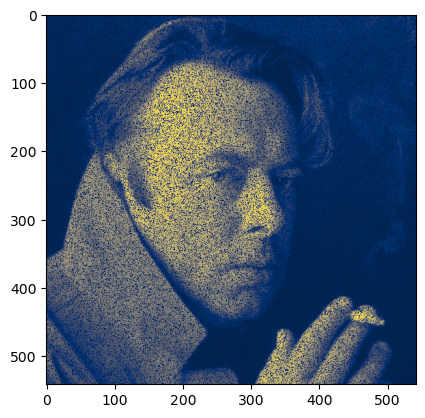

In [10]:
img = imgray.copy()
img0 = imgray.copy()
m,n = img.shape
zero_mask = np.random.rand(m, n) > 0.75
img[zero_mask] = 0
nonzeros = (~zero_mask).sum() 

plt.imshow(img,cmap='cividis')

In [11]:
# initializing 
Y = np.zeros((m, n))
delta = m*n/nonzeros 

lam = 0.95 # lambda
tau = lam*delta

# algorithm
y_change, error, yerror = [], [], 10
for _ in range(25):
    
    u, s, vh = np.linalg.svd(Y,full_matrices=False)
    s_t = np.maximum(s-tau, 0)
    
    Z = (u[:, :n]*s_t)@vh # reconstruction of matrix
    
    P = img-Z
    P[zero_mask] = 0
    
    Y0 = Y.copy()
    Y = Z + delta*P
    
    # collections for plotting
    yerror = ((Y-Y0)**2).sum()
    y_change.append(yerror) 
    error.append(np.mean((img0-Z)**2)) 

no_singles = np.sum(s_t>0)
print(f'singulars > 0: {no_singles}',end='\r')

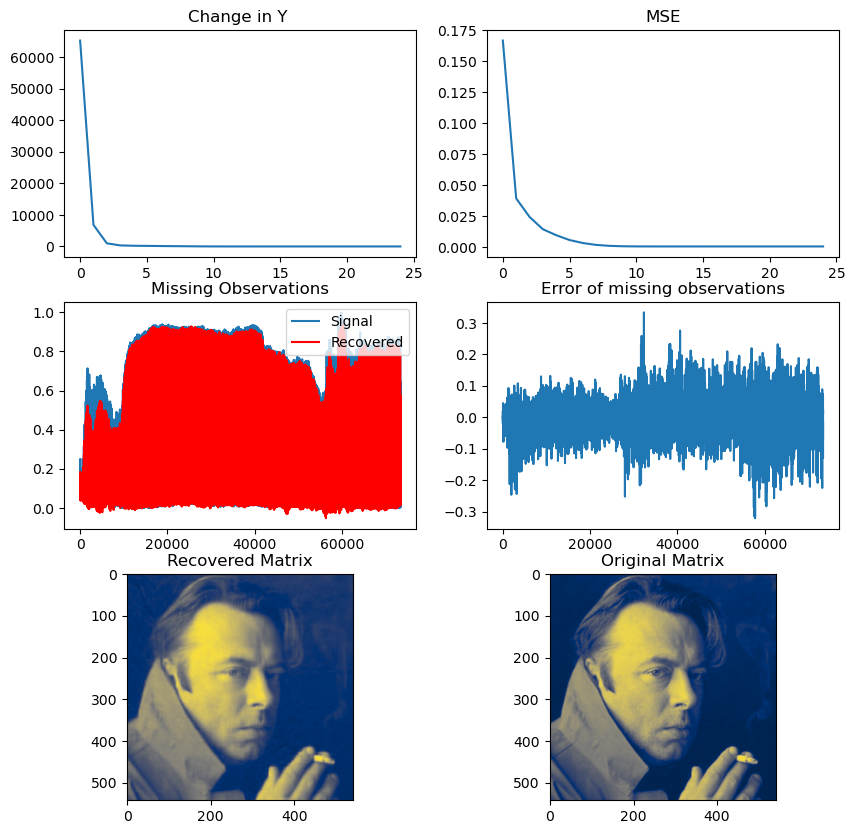

In [12]:
Xr = img0[zero_mask]
Zr = Z[zero_mask]

# plot the results
fig, ax = plt.subplots(3,2,figsize=(10,10))
ax[0,0].plot(y_change)
ax[0,0].set_title('Change in Y ')

ax[0,1].plot(error)
ax[0,1].set_title('MSE')

ax[1,0].plot(Xr, label='Signal')
ax[1,0].plot(Zr, 'r', label='Recovered')
ax[1,0].set_title('Missing Observations')
ax[1,0].legend()

ax[1,1].plot(Zr-Xr)
ax[1,1].set_title('Error of missing observations')

ax[2,0].imshow(Z,cmap='cividis')
ax[2,0].set_title('Recovered Matrix')

ax[2,1].imshow(img0,cmap='cividis')
ax[2,1].set_title('Original Matrix')
plt.show()

#### the recovered image is a bit blury; I'll sharpen it by matrix convolution with a sharpening matrix

In [13]:
# # # add padding
def pad(M):
    m, n = M.shape
    v_pad = np.zeros(n) # vertical pad, stacking rows
    h_pad = np.zeros(m+2).reshape(m+2,1) # horizontal pad, concatenating columns
    Mp = np.vstack((M,v_pad))
    Mp = np.vstack((v_pad,Mp))
    Mp = np.hstack((h_pad,Mp))
    Mp = np.hstack((Mp,h_pad))
    return Mp
# # # remove padding
def depad(M):
    m, n = M.shape
    M = M[1:m-1,:]
    M = M[:,1:n-1]
    return M

In [14]:
# # # convolve matrix
def convolve(M,K,s:int=3):
    # s is the width/length of the moving neighborhood
    m, n = M.shape
    CM = np.zeros((m,n))
    for i in range(m-s+1):
        for j in range(n-s+1):
            subM = M[i:i+s,j:j+s]
            Cij = np.sum(np.multiply(subM,K))
            CM[i+1,j+1] = Cij
    return CM

In [15]:
# # # sharpening matrix for convolution
SH = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])

In [16]:
Z_sharp = depad(convolve(pad(Z),SH))

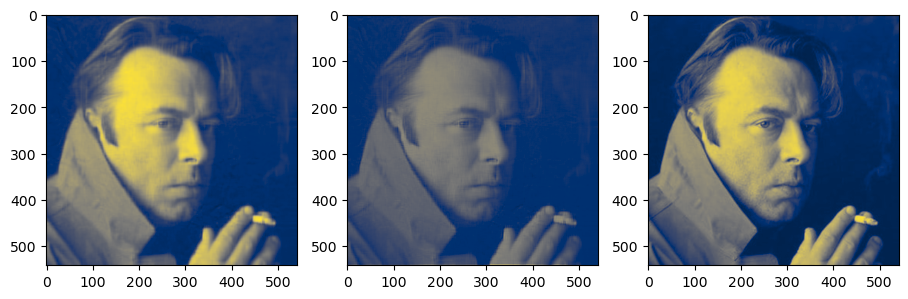

In [17]:
fig, ax = plt.subplots(1,3,figsize=(11,10))
ax = ax.flatten()
ax[0].imshow(Z,cmap='cividis')
ax[1].imshow(Z_sharp,cmap='cividis')
ax[2].imshow(imgray,cmap='cividis')

#### quick edge detection

The edge detection on the original image is much sharper. The difference is quite apparent. The smoothing that took place in matrix completion softened the edges in the recontructed image.The sharpening of the reconstructed image does amplify the edges just a bit compared.

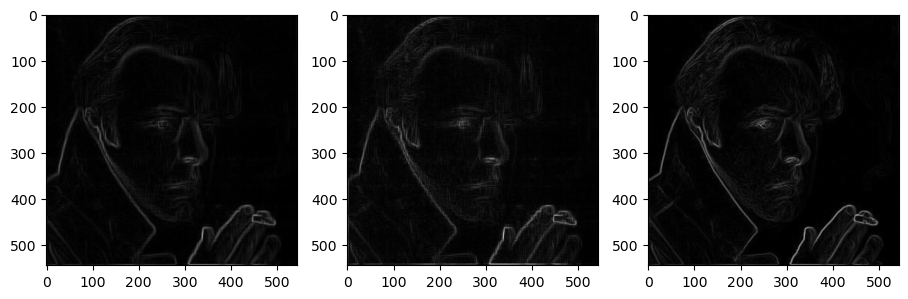

In [25]:
# # # Sobel matrices
Mx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
My = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])

EP = pad(Z_sharp)
Fx = convolve(EP,Mx)
Fy = convolve(EP,My)
Fs = np.sqrt(np.multiply(Fx,Fx) + np.multiply(Fy,Fy))

EP = pad(imgray)
Fx = convolve(EP,Mx)
Fy = convolve(EP,My)
Fog = np.sqrt(np.multiply(Fx,Fx) + np.multiply(Fy,Fy))

EP = pad(Z)
Fx = convolve(EP,Mx)
Fy = convolve(EP,My)
Fz = np.sqrt(np.multiply(Fx,Fx) + np.multiply(Fy,Fy))

fig, ax = plt.subplots(1,3,figsize = (11, 10))
ax = ax.flatten()
ax[0].imshow(Fz,cmap='gray')
ax[1].imshow(Fs,cmap='gray')
ax[2].imshow(Fog,cmap='gray')